In [1]:
import numpy as np
import random
import gym
import random
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
from IPython.display import clear_output
import time

In [5]:
#Setting up the environment
env = gym.make('Taxi-v3')

env.reset()

#Current State
print(env.s)

# 5x5x5x4 grid = 500 states
print ("Number of states:", env.observation_space.n)

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
#correspond to [0,1,2,3,4,5] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.action_space.n)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

state = env.reset()
print ("Decoded state:", list(env.decode(state)))
env.render()

326
Number of states: 500
Number of actions that an agent can take: 6
Action taken: east
Transition probability: {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
Next state: 346
Reward recieved: -1
Terminal state: False
Decoded state: [0, 2, 0, 2]


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [6]:
def stateData(state):
  picdrop = state%20
  pos = state//20
  y = pos//5
  x = pos%5
  drop = picdrop%4
  passenger = picdrop//4
  return x,y,drop,passenger

In [7]:
def egreedy_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    #print('greedy', np.argmax(q_values[state]),q_values.shape)
    return np.argmax(q_values[state])
  choice = random.randint(0,q_values.shape[-1]-1)
  #print('random',choice,q_values.shape)
  return choice


In [8]:
policyOptionR = np.array([[1,3,0,0,0],
                 [1,3,0,0,0],
                 [1,3,3,3,3],
                 [1,1,1,1,1],
                 [1,1,1,1,1]
                 ])
policyOptionG = np.array([[0,0,2,2,1],
                 [0,0,2,2,1],
                 [2,2,2,1,1],
                 [1,2,1,1,1],
                 [1,2,1,1,1]
                 ])
policyOptionY = np.array([[0,3,0,0,0],
                          [0,3,0,0,0],
                          [0,3,3,3,3],
                          [0,1,1,1,3],
                          [0,1,3,1,3]
                          ])
policyOptionB = np.array([[0,0,0,0,3],
                          [0,0,0,0,3],
                          [2,2,2,0,3],
                          [1,1,1,0,3],
                          [1,1,1,0,3]
                          ])
policyOpt = [policyOptionR,policyOptionG,policyOptionY,policyOptionB]


In [11]:
nX = 5; nY = 5; nPas = 5; nDrop = 4

In [13]:
nO = 4 #number of options
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}

In [14]:
Qopt = {i:np.zeros((env.env.observation_space.n//20,env.env.action_space.n-2)) for i in range(nO)} #Q-values for each option
eps = {i:0.01 for i in range(env.observation_space.n)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5
count = 0
Neps = 1500
gamma = 0.9
alpha = 0.1

In [20]:
def Option(env,state,Q,goalNum,eps=0.1,goal = goal):
  optdone = False
  x,y,pas,drop=env.decode(state)

  if (x==goal[goalNum][0] and y==goal[goalNum][1]):
      #print('Reached ',goalNum)
      optdone = True
      if pas == goalNum:
        optact = 4
      elif drop == goalNum:
        optact = 5
      else:
        optact = 1 if (goalNum in [0,1]) else 0
  else:
    optact = egreedy_policy(Q[goalNum], 5*x+y, epsilon=eps)
  return [optact,optdone]

In [15]:
def Sub(state, nPas = nPas, nDrop = nDrop):
  _,_,pas,drop = env.decode(state)
  subState = nDrop*pas+drop
  return subState


In [21]:
#### Intra Option Q-Learning

rewards3 = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}



# Add parameters you might need here
gamma = 0.9
alpha = 0.1

#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_IOQL = np.zeros((nPas*nDrop,nO))
updates_IOQL = np.zeros((nPas*nDrop,nO))

Qopt = {i:np.zeros((env.env.observation_space.n//20,env.env.action_space.n-2)) for i in range(nO)} #Q-values for each option


eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5

count = 0
Neps = 1500

# Iterate over Neps episodes
for i in range(Neps):
    state = env.reset()
    done = False
    tot_rew=0

    # While episode is not over
    while not done:

        # Choose action
        _,_,pas,drop = env.decode(state)
        subState = nDrop*pas+drop
        action = egreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)


        option = action
        optdone = False
        prev = state
        while not optdone and not done:

            # Think about what this function might do?
            optact,optdone = Option(env,state,Qopt,option,eps[option])
            next_state, reward, done,_ = env.step(optact)

            tot_rew+=reward


            #Option Policy Learning
            [x,y,_,_]=  list(env.decode(state))
            [x1,y1,_,_]=  list(env.decode(next_state))



            eps[option] = max(eps_min,eps_decay*eps[option])
            tot_rew+=reward
            reward_surr = reward
            if optdone:
              reward_surr = 20
            if optact<4:
              Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])



            #finding all options giving same action call

            for o in range(nO):
              optact_o,optdone_o = Option(env,state,Qopt,o,eps[o])
              if optact_o == optact:
                eps[o] = max(eps_min,eps_decay*eps[o])
                if optdone_o:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
                else:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o])

                updates_IOQL[Sub(state), o] += 1
            state = next_state

    rewards3.append(tot_rew)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

Success (1476/1500) = 98.4%


In [24]:
state = env.reset()
done = False
tot_rew=0

# While episode is not over
while not done:

    # Choose action
    _,_,pas,drop = env.decode(state)
    subState = nDrop*pas+drop
    action = egreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
    eps_main = max(eps_min,eps_main*eps_decay)


    option = action
    optdone = False
    prev = state
    while not optdone and not done:

        # Think about what this function might do?
        optact,optdone = Option(env,state,Qopt,option,eps[option])
        next_state, reward, done,_ = env.step(optact)
        clear_output(wait=True)
        print(env.render())
        time.sleep(T)

        tot_rew+=reward


        #Option Policy Learning
        [x,y,_,_]=  list(env.decode(state))
        [x1,y1,_,_]=  list(env.decode(next_state))



        eps[option] = max(eps_min,eps_decay*eps[option])
        tot_rew+=reward
        reward_surr = reward
        if optdone:
          reward_surr = 20
        if optact<4:
          Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])


        _ ,optdone_next = Option(env,state,Qopt,option,eps[option])

        #finding all options giving same action call

        for o in range(nO):
          optact_o,optdone_o = Option(env,state,Qopt,o,eps[o])
          if optact_o == optact:
            eps[o] = max(eps_min,eps_decay*eps[o])
            if optdone_o:
              q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
            else:
              q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o])

            updates_IOQL[Sub(state), o] += 1
        state = next_state

rewards3.append(tot_rew)
x,y,pas,drop = env.decode(state)


None


Text(0.5, 1.0, 'Policy over options learnt by Intra Options')

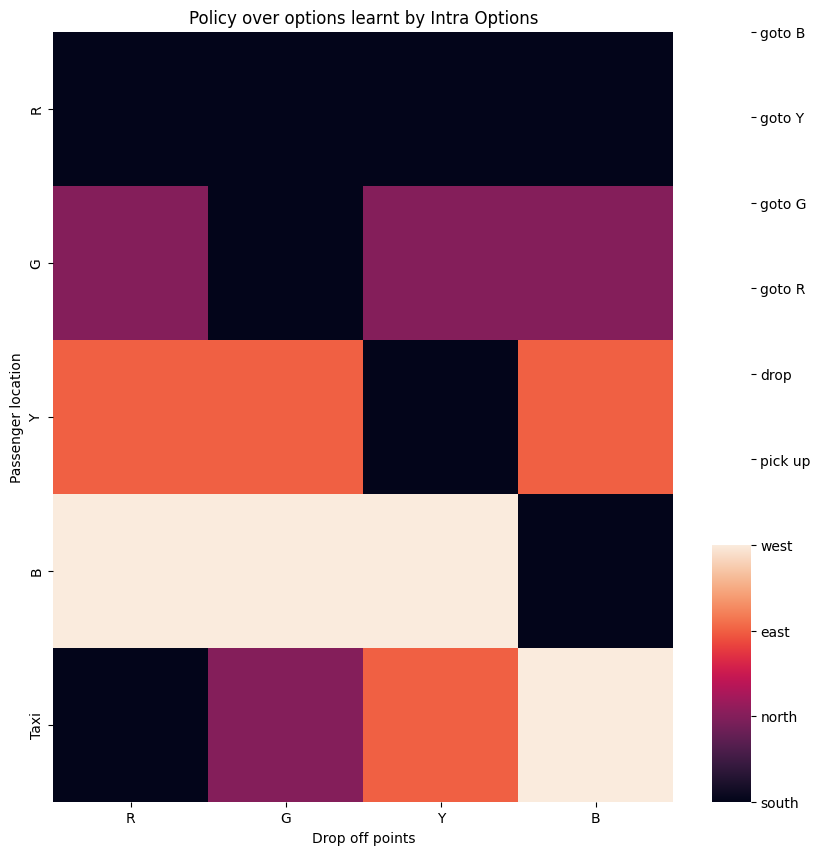

In [26]:
Qmax_IOQL = np.argmax(q_values_IOQL[:,-4:],axis = 1).reshape(5,4)

figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_IOQL,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'])
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(10)])
c_bar.set_ticklabels(['south','north','east','west','pick up','drop','goto R','goto G', 'goto Y', 'goto B'])
#c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])
axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy over options learnt by Intra Options')

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (4).

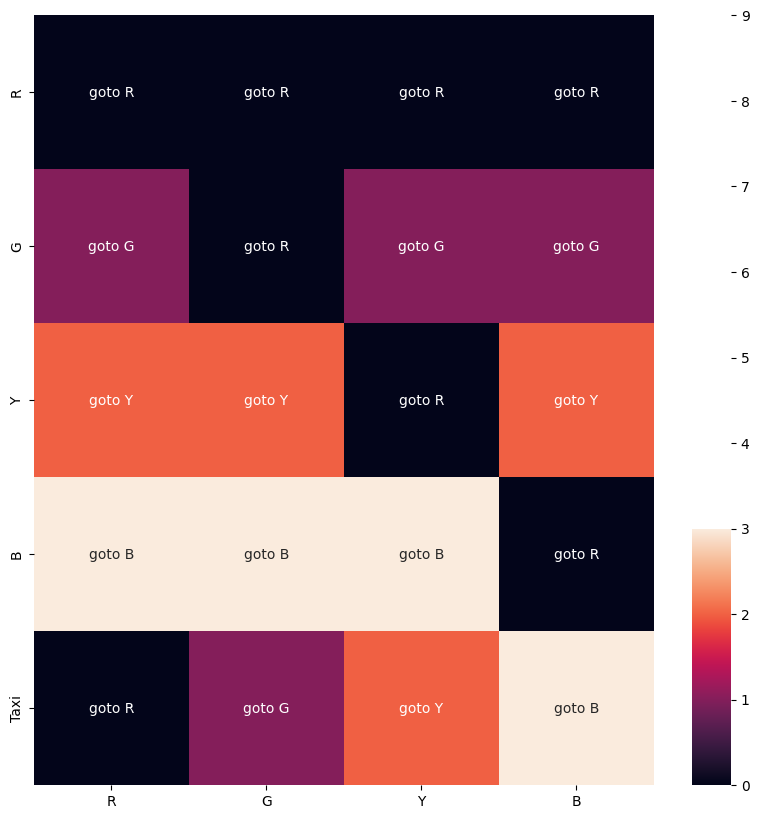

In [27]:
Qmax_IOQL = np.argmax(q_values_IOQL,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_IOQL)

figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_IOQL,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text, fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(10)])

c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])
#c_bar.set_ticklabels(['south','north','east','west','pick up','drop'])
axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy over default actions learnt by Intra Options')


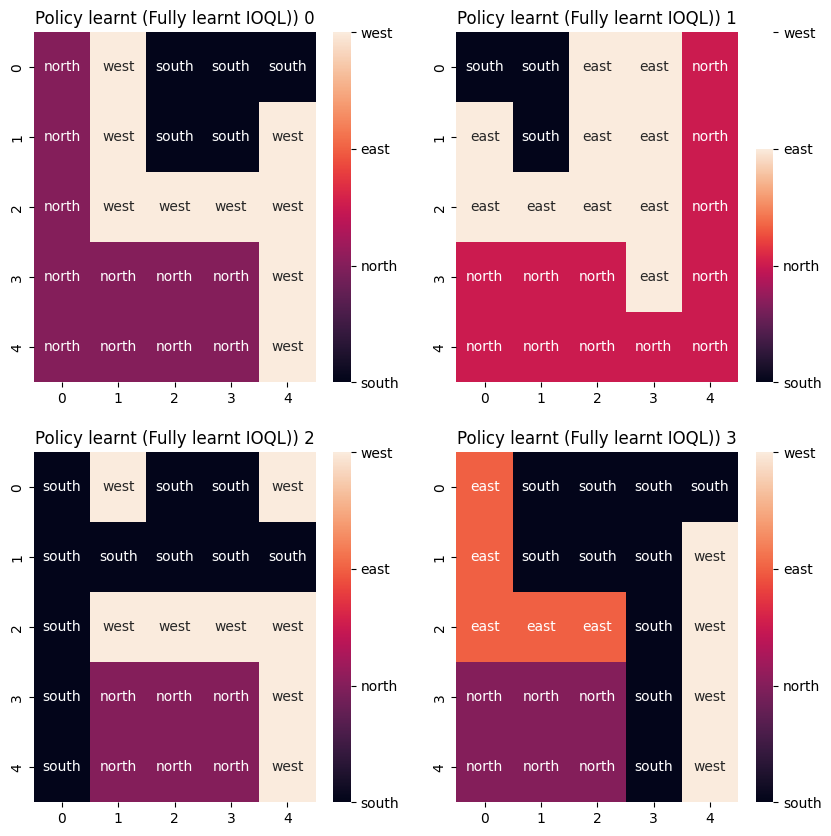

In [28]:
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
    axis[i,j].set_title("Policy learnt (Fully learnt IOQL)) {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])